In [11]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_CLASSES  = 5

# data frame of current competition
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")
df_2019.id_code = df_2019.id_code.apply(lambda x: "modified_" + x) 
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False)

# 2019 data frame 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")
df_2015["id_code"]   = df_2015.image
df_2015["diagnosis"] = df_2015.level
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)

# valid_2019['diagnosis'].value_counts().plot(kind='bar')
# plt.title('Samples Per Class')

# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

                        id_code diagnosis           labels
3564  modified_f850cb51fdba.png         4  [0, 1, 2, 3, 4]
3235  modified_e13412678eff.png         3     [0, 1, 2, 3]
2981  modified_cf1b9d26d38d.png         4  [0, 1, 2, 3, 4]
3083  modified_d6b109c82067.png         0              [0]
3546  modified_f6f433f3306f.png         3     [0, 1, 2, 3]


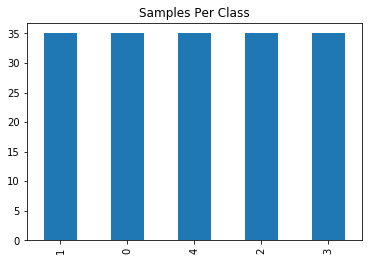

In [64]:

def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    #y_val= np.argmax(y_val, axis=1)
    return y_val

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x + 1)])
    valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x + 1)])

    train.diagnosis = train.diagnosis.astype('str')
    valid.diagnosis = valid.diagnosis.astype('str')

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == str(diagnosis)].index
            indexes_train = train[train['diagnosis'] == str(diagnosis)].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution later, and take a smaller batch if the train size is larger than 10000
    frac = 1
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

# plot example
_, df_to_plot = get_train_valid_df(year="2019")
df_to_plot['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')
print(df_to_plot.head(5))

# df_to_plot.columns

2370


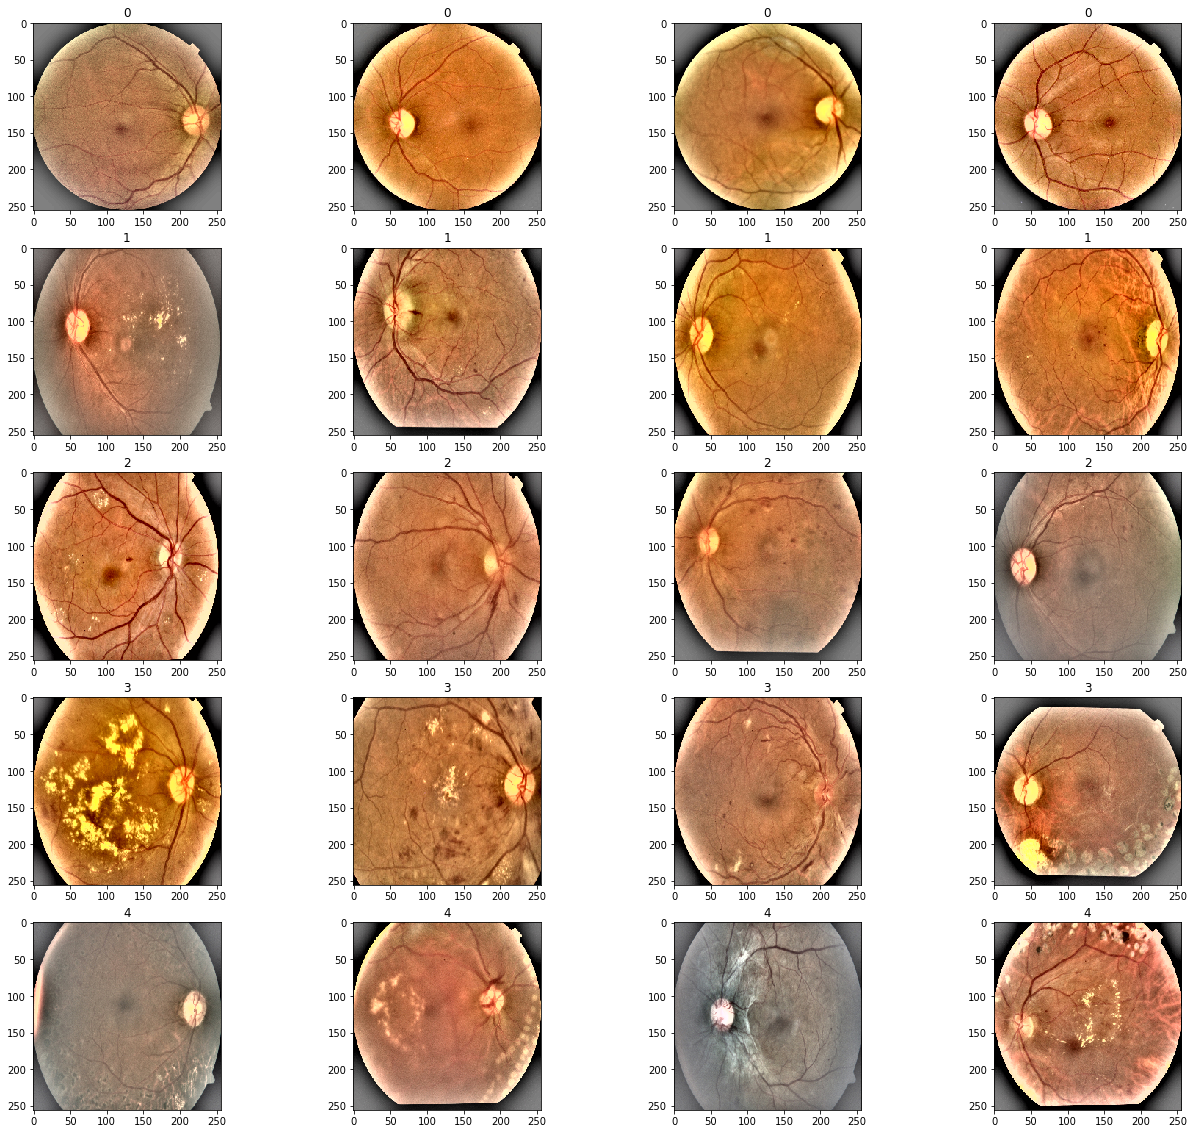

In [4]:
# # display some data
# df_example, _ = get_train_valid_df(year="2019")

# # Display some random images from Data Set with class categories.
# figure=plt.figure(figsize=(22,20))
# for target_class in (df_example['diagnosis'].unique()):
#     for i, (idx, row ) in enumerate(df_example.loc[df_example.diagnosis == target_class]
#                                     .sample(4)
#                                     .iterrows()):
#         # open the file
#         imagefile = f"../aptos2019/train_images/{row['id_code']}" 
#         img = cv2.imread(imagefile)
        
#         # original version
#         rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         ax = figure.add_subplot(5,4, int(target_class)*4+i+1)
#         plt.imshow(rgb)
#         ax.set_title(target_class)
        

In [52]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(800*jitter),
                                       brightness_range=[1-jitter, 1+jitter],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[(1-jitter), (1+jitter/2)],
                                       fill_mode="reflect",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="id_code", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen

gc.collect()


1267

2370
Found 790 validated image filenames belonging to 5 classes.
Found 175 validated image filenames belonging to 5 classes.


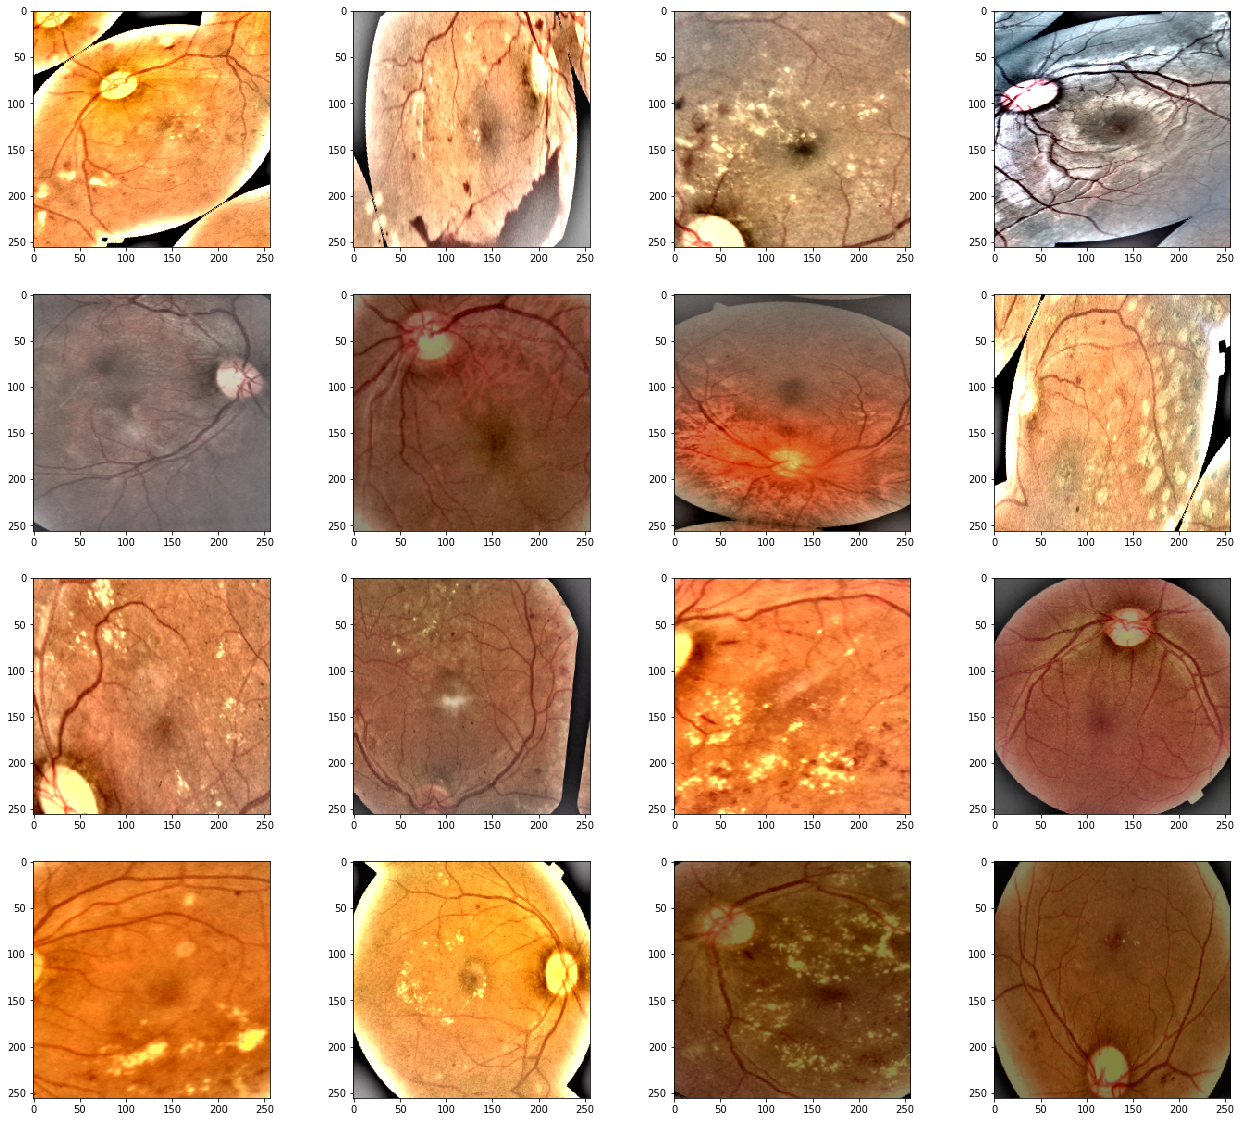

In [13]:
# train_sample_gen, valid_sample_gen = generator(jitter=0.5)

# # Display some data generation
# figure=plt.figure(figsize=(22,20))
# for batch in valid_sample_gen:
#     for j in range(16):
#         ax = figure.add_subplot(4,4, j+1)
#         batch[0][j] = np.clip(batch[0][j], 0, 1)
#         plt.imshow(batch[0][j])
#     break

In [7]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 15
        y_pred = []
        y_val = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            predictions = predictions > 0.5
            y_pred.extend(label_convert(predictions))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(val_kappa)
        print(confusion_matrix(y_val, y_pred))
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.84:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(f"dense-multi-{val_kappa:.4f}.h5")


In [12]:
def create_model():
    
    model = Sequential()
    model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
                          include_top=False, 
                          input_shape=(IMG_DIM,IMG_DIM,CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()



W0814 09:36:45.060064 139629899491072 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [65]:
 for jitter in [0.4, 0.2, 0.05]:
    
    model.compile(optimizer=Adam(lr=0.00005*2*jitter), loss='binary_crossentropy',  metrics=['accuracy'])
    
    print("           -----------------------------------", jitter, "-----------------------------------")
    
    for even_distrib in [False, True]:
        
        for year in ["2015"]:

            print("           -   -   -   -   -   -   -   -   ", year, even_distrib, "-   -   -   -   -   -   -   -   -")
            # these need to be global for the kappa callback
            train_generator, valid_generator = generator(jitter=0.1, year=year, even_distrib=even_distrib)

            # Call backs during training            
            kappa_callbacks = Metrics(valid_generator)
            reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                           min_lr=1e-8, mode='auto', verbose=1)

            # train the model for 12 epochs
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                          validation_data=valid_generator,
                                          validation_steps=valid_generator.n // valid_generator.batch_size,
                                          epochs=6, workers=6, verbose=1,
                                          callbacks=[reduce_lr, kappa_callbacks],
                                         )
    
    gc.collect()

           ----------------------------------- 0.4 -----------------------------------
           -   -   -   -   -   -   -   -    2015 False -   -   -   -   -   -   -   -   -
Found 28100 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.
Epoch 1/6
878/878 [==============================] - 1155s 1s/step - loss: 0.1880 - acc: 0.9259 - val_loss: 0.1725 - val_acc: 0.9344
0.6194356503785272
[[342   7   8   0   0]
 [ 26   2   3   0   0]
 [ 37   4  28   2   0]
 [  0   0   7   3   0]
 [  3   0   2   3   3]]
Epoch 2/6
878/878 [==============================] - 1082s 1s/step - loss: 0.1786 - acc: 0.9306 - val_loss: 0.1713 - val_acc: 0.9350
0.6301301657301372
[[356   3   1   0   0]
 [ 29   1   4   0   0]
 [ 33   6  26   0   0]
 [  3   0   6   1   0]
 [  2   0   4   1   4]]
Epoch 3/6
878/878 [==============================] - 1083s 1s/step - loss: 0.1704 - acc: 0.9336 - val_loss: 0.1602 - val_acc: 0.9374
0.6470663093967182
[[356   7   7

878/878 [==============================] - 1089s 1s/step - loss: 0.1325 - acc: 0.9489 - val_loss: 0.1526 - val_acc: 0.9424

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
0.6634218775779575
[[338   7  10   0   0]
 [ 30   3   2   0   0]
 [ 31   4  26   8   0]
 [  1   0   8   3   0]
 [  0   0   5   3   1]]
Epoch 4/6
878/878 [==============================] - 1088s 1s/step - loss: 0.1297 - acc: 0.9506 - val_loss: 0.1512 - val_acc: 0.9442
0.5658183592161965
[[343   7  10   0   0]
 [ 40   3   4   0   0]
 [ 32   2  23   2   1]
 [  2   0   2   2   0]
 [  0   0   5   0   2]]
Epoch 5/6
878/878 [==============================] - 1090s 1s/step - loss: 0.1304 - acc: 0.9502 - val_loss: 0.1534 - val_acc: 0.9430
0.7010463378176383
[[332   7   8   0   1]
 [ 32   4   2   0   0]
 [ 26   6  44   2   0]
 [  0   0   4   4   0]
 [  0   1   2   3   2]]
Epoch 6/6
878/878 [==============================] - 1092s 1s/step - loss: 0.1301 - acc: 0.9501 - val_loss: 0.1493 - val_acc:

In [67]:
model.save(f"dense-multi-2015-run.h5")

# Compare the average of 5 randomised jitters to a non-jittered val

In [66]:
def compare_prediction_process(year="2019"):

    _, valid_df = get_train_valid_df(year=year, even_distrib=True)
    
    valid_df.diagnosis = valid_df.diagnosis.astype(int)

    # with jitter
    num = 7
    prediction_lists = np.zeros((valid_df.index.size, num, 5))
    for i in range(num):
        datagen = datagen_with_flow(dataGenerator(0.03), valid_df, f"../aptos{year}/train_images/")
        prediction_lists[:, i] = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)

    predictions = np.median(prediction_lists, axis=1)
    y_pred = label_convert(predictions > 0.5)
    y_val  = valid_df.diagnosis
#     print(prediction_lists[0])
#     print(predictions[0])
#     print
#     print(y_val.values[0])
    
    print("With jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
    print(confusion_matrix(y_val, y_pred))
          
    # no jitter
    datagen = datagen_with_flow(dataGenerator(0), valid_df, f"../aptos{year}/train_images/")
    predictions = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)
    y_pred = label_convert(predictions > 0.5)
    y_val  = valid_df.diagnosis
    
    print("With no jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
    print(confusion_matrix(y_val, y_pred))
            
    
    
    
compare_prediction_process("2015")
gc.collect()

Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 17s 699ms/step
Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 19s 781ms/step
Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 18s 751ms/step
Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 17s 709ms/step
Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 18s 741ms/step
Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 17s 725ms/step
Found 756 validated image filenames belonging to 5 classes.
24/24 [==============================] - 18s 729ms/step
With jitter:  0.6622365056274984
[[150   0   0   0   1]
 [138   7   6   0   0]
 [ 75  18  52   6   0]
 [ 13   8  75  55   1]
 [ 18   5  25  38  65]]
Found 756 validated image filenames bel

1569